In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AICV

#  IoU & NMS

## 1. Import packages.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data as data
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


### Funtion for visualization
def draw_bb(img, boxes, color='r'):
    fig,ax = plt.subplots(1)
    for box in boxes:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()

### Fuction for vislualize bounding with two differnt colors
def draw_bb2(img, boxes1, boxes2, color1='r', color2='g'):
    fig,ax = plt.subplots(1)
    for box in boxes1:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color1,facecolor='none')
        ax.add_patch(rect)
    for box in boxes2:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color2,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()

## 2. PASCAL VOC2007 Dataset

In [ ]:
class PASCAL_DATASET(data.Dataset):
    def __init__(self, data_root, img_list_file):
        self.data_root = data_root
        self.img_list = []
        self._load_img_name_list(img_list_file)

    def _load_img_name_list(self, img_list_file):
        with open(img_list_file) as f:
            self.img_list = f.read().splitlines()

    def _load_annotation(self, img_path):
        filename = os.path.join(self.data_root, 'Annotations', img_path + '.xml')
        tree = ET.parse(filename)
        objs = tree.findall('object')
        num_objs = len(objs)
        boxes = np.zeros((num_objs, 4), dtype=np.int32)
        gt_classes_str = []

        for ix, obj in enumerate(objs):
            bbox = obj.find('bndbox')
            # Make pixel indexes 0-based
            x1 = float(bbox.find('xmin').text) - 1
            y1 = float(bbox.find('ymin').text) - 1
            x2 = float(bbox.find('xmax').text) - 1
            y2 = float(bbox.find('ymax').text) - 1
            gt_classes_str.append(obj.find('name').text)
            boxes[ix, :] = [x1, y1, x2, y2]

        return boxes, gt_classes_str

    def __len__(self,):
        return len(self.img_list)

    def __getitem__(self, index):
        img_path = self.img_list[index]
        img = Image.open(os.path.join(self.data_root, 'JPEGImages', img_path + '.jpg'))
        boxes, gt_classes_str = self._load_annotation(img_path)
        return img, boxes, gt_classes_str

In [ ]:
pascal_data = PASCAL_DATASET(data_root='./VOC2007',img_list_file='./VOC2007/ImageSets/Main/train.txt')

In [ ]:
pascal_it = iter(pascal_data)
img, gt_boxes, gt_box_classes = next(pascal_it)

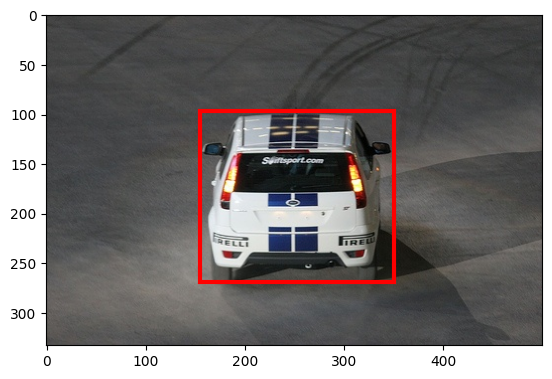

In [ ]:
draw_bb(img, gt_boxes)

## 3. Calculate IoU!

In [ ]:
### Our ground truth box
print(gt_boxes)
print(gt_boxes.shape)

[[155  96 350 269]]
(1, 4)


In [ ]:
### Assume we have following predictions from network
predicted_boxes = np.zeros((4, 4), dtype=np.int32)
predicted_boxes[0, :] = [100, 80, 320, 240]
predicted_boxes[1, :] = [50, 40, 160, 120]
predicted_boxes[2, :] = [200, 150, 300, 300]
predicted_boxes[3, :] = [250, 50, 450, 250]

### Predicted_scores means confidence score
predicted_scores = np.array([0.9, 0.8, 0.7, 0.6])

print(predicted_boxes)
print(predicted_boxes.shape)

[[100  80 320 240]
 [ 50  40 160 120]
 [200 150 300 300]
 [250  50 450 250]]
(4, 4)


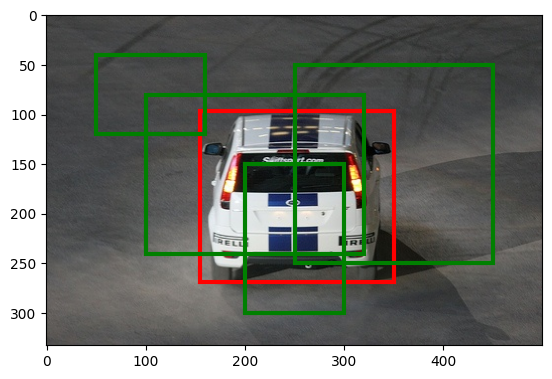

In [ ]:
draw_bb2(img, gt_boxes, predicted_boxes)

In [ ]:
### Convert to pytorch tensors
gt_boxes = torch.from_numpy(gt_boxes).float()
predicted_boxes = torch.from_numpy(predicted_boxes).float()
predicted_scores = torch.from_numpy(predicted_scores).float()
print(predicted_boxes)

tensor([[100.,  80., 320., 240.],
        [ 50.,  40., 160., 120.],
        [200., 150., 300., 300.],
        [250.,  50., 450., 250.]])


In [ ]:
def bbox_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes
    box 1 : (1, 4) shaped pytorch tensors - sinlge GT bounding box
    box 2 : (N, 4) shaped pytorch tensors - multiple predictions from network
    """
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]

    ### Intersection rectangle coordinate
    ### Return (1,4) tensor
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)

    ### Practice
    ### Clamps all elements in input into the range [min, max]
    inter_area = torch.clamp(inter_rect_x2-inter_rect_x1, min=0.)\
            * torch.clamp(inter_rect_y2-inter_rect_y1, min=0.)


    ### Calculate IoU
    area_1 = (b1_x2-b1_x1) * (b1_y2-b1_y1)
    area_2 = (b2_x2-b2_x1) * (b2_y2-b2_y1)
    iou = inter_area/(area_1+area_2-inter_area)

    return iou

In [ ]:
### Get IoU score for each prediction boxes
ious = bbox_iou(gt_boxes, predicted_boxes)

In [ ]:
print(ious)
print(predicted_boxes)

tensor([0.5260, 0.0028, 0.3231, 0.2640])
tensor([[100.,  80., 320., 240.],
        [ 50.,  40., 160., 120.],
        [200., 150., 300., 300.],
        [250.,  50., 450., 250.]])


## 4. Threshold bounding boxes based on IoU scores

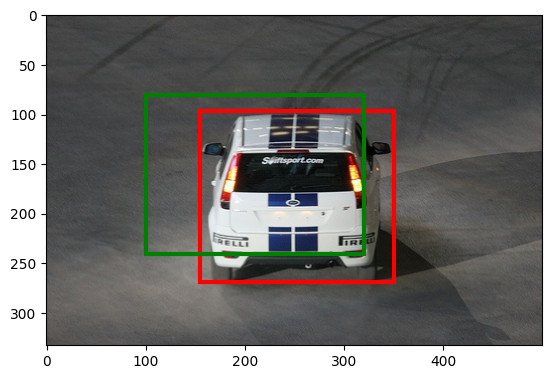

In [ ]:
threshold = 0.5
### Find indices where condition is True
th = np.where(ious.numpy() > threshold)
th_boxes = predicted_boxes[th]
draw_bb2(img, gt_boxes, th_boxes)

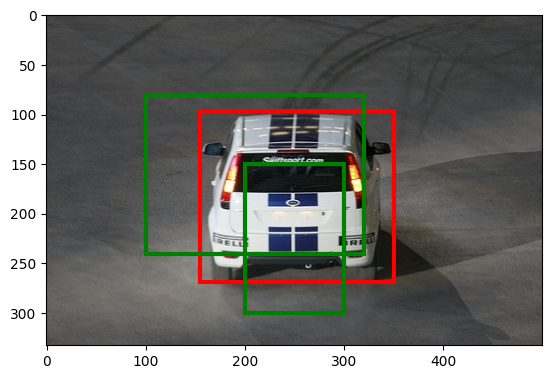

In [ ]:
threshold = 0.3
th = np.where(ious.numpy() > threshold)
th_boxes = predicted_boxes[th]
draw_bb2(img, gt_boxes, th_boxes)

## 5. Non-maximum suppression (NMS)

In [ ]:
def nms(boxes, scores, threshold):
    """
    boxes: (N, 4), each row-> (x1, y1, x2, y2), x2 > x1, y2 > y1
    scores: (N,), each value in [0, 1]
    threshold: iou threshold
    """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort() ### Sort in ascending order and save the indices

    keep = []

    while len(order) > 0:
        ### The index with the highest score.
        idx = order[-1]
        ### Keep it
        keep.append(boxes[idx])
        ### remove the index from the candidate list.
        order = order[:-1]

        if len(order) == 0:
            break ### Get out of while loop

        ### Order bounding boxes according to the order.
        xx1 = x1[order]
        xx2 = x2[order]
        yy1 = y1[order]
        yy2 = y2[order]

        ### Intersection coordinate
        ix1 = torch.max(xx1, boxes[idx, 0])
        iy1 = torch.max(yy1, boxes[idx, 1])
        ix2 = torch.min(xx2, boxes[idx, 2])
        iy2 = torch.min(yy2, boxes[idx, 3])

        ### Width and height of the intesection, calculate intersection
        w = torch.clamp(ix2-ix1, min=0.)
        h = torch.clamp(iy2-iy1, min=0.)

        inter = w*h
        union = areas[order] + areas[idx] - inter
        iou = inter / union

        ### Keep the boxes with iou less than threshold
        order = order[iou<threshold]

    return keep

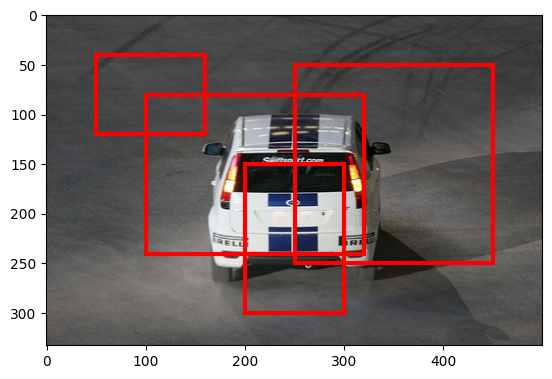

In [ ]:
draw_bb(img, predicted_boxes)

In [ ]:
nms_boxes = nms(predicted_boxes, predicted_scores, 0.2)
print(nms_boxes)

[tensor([100.,  80., 320., 240.]), tensor([ 50.,  40., 160., 120.]), tensor([250.,  50., 450., 250.])]


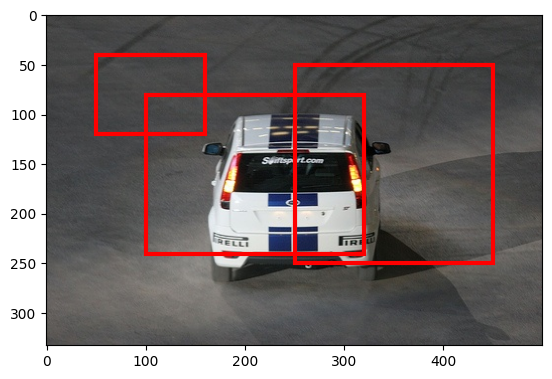

In [ ]:
draw_bb(img, torch.vstack(nms_boxes))